# Data Collection

In [ ]:
pip install stackapi pandas matplotlib seaborn requests

In [ ]:
from stackapi import StackAPI
import pandas as pd
import time
from tqdm import tqdm
import math

def save_data(data, mode='w', header=True):
    """
    Save data to CSV file
    mode: 'w' for write (overwrite), 'a' for append
    header: Whether to write the header row
    """
    df = pd.DataFrame(data)
    df.to_csv('nlp_stackoverflow_data.csv',
              mode=mode,
              header=header,
              index=False)

page = 1
SITE = StackAPI('stackoverflow', key='rl_7fwzqpDysq7fFPGd3LmzQEWz3')
SITE.page_size = 100

while page <= 209:
  start_page =page
  questions = SITE.fetch('questions',
                              tagged=['nlp'],
                              sort='creation',
                              page=start_page,
                              filter='withbody')

  # Initialize progress bar
  pbar = tqdm(total=len(questions['items']))
  all_questions = []
  for i, question in enumerate(questions['items']):
    try:
      # Get answers for this question
      answers = SITE.fetch(f'questions/{question["question_id"]}/answers',
                        filter='withbody',
                        sort='votes')

      # Get accepted answer if exists
      accepted_answer = None
      other_answers = []

      if 'accepted_answer_id' in question:
          for answer in answers['items']:
              if answer['answer_id'] == question['accepted_answer_id']:
                  accepted_answer = answer['body']
              else:
                  other_answers.append(answer['body'])

      question_data = {
          'title': question['title'],
          'description': question['body'],
          'tags': question['tags'],
          'accepted_answer': accepted_answer,
          'other_answers': other_answers[:1] if other_answers else None,
          'creation_date': question['creation_date'],
          'view_count': question['view_count'],
          'score': question['score']
      }
      all_questions.append(question_data)
      pbar.update(1)

      # Save progress every 10 items
      if len(all_questions) >= 10:
          save_data(all_questions, mode='a', header=False)
          all_questions = []  # Clear the list after saving

    except Exception as e:
      print(f"Error processing question {question['question_id']}: {e}")
      ques_id = question['question_id']

  pbar.close()
  save_data(all_questions, mode='a', header=False)
  print(f"Collected data for {questions['page']} pages")
  page = questions['page'] + 1

# Raw Data Visualization

In [8]:
import pandas as pd
import re
import spacy
import warnings
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from datetime import datetime
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Read the data from csv file
df = pd.read_csv('nlp_stackoverflow_data.csv')

In [10]:
# Modify creation date to normal date format from linux date format
df['creation_date'] = pd.to_datetime(df['creation_date'], unit='s')

In [11]:
# Print some basic statistics
print("Dataset Statistics:")
print(f"Total number of posts: {len(df)}")
print(f"Date range: from {df['creation_date'].min().date()} to {df['creation_date'].max().date()}")
print(f"\nNumber of posts without any answer (accepted or other): {df[(df['accepted_answer'].isnull()) & (df['other_answers'].isnull())].shape[0]}")
print(f"Average view count: {df['view_count'].mean():.2f}")
print(f"Average score: {df['score'].mean():.2f}")

# Print top 5 most viewed questions
print("\nTop 5 Most Viewed Questions:")
top_views = df.nlargest(5, 'view_count')[['title', 'view_count']]
for idx, row in top_views.iterrows():
    print(f"Views: {row['view_count']}, Title: {row['title']}")

Dataset Statistics:
Total number of posts: 20786
Date range: from 2008-08-22 to 2025-04-09

Number of posts without any answer (accepted or other): 12122
Average view count: 2089.22
Average score: 2.07

Top 5 Most Viewed Questions:
Views: 472647.0, Title: spaCy: Can&#39;t find model &#39;en_core_web_sm&#39; on windows 10 and Python 3.5.3 :: Anaconda custom (64-bit)
Views: 333792.0, Title: How to compute precision, recall, accuracy and f1-score for the multiclass case with scikit learn?
Views: 316362.0, Title: How to compute the similarity between two text documents?
Views: 309862.0, Title: How to get rid of punctuation using NLTK tokenizer?
Views: 233910.0, Title: googletrans stopped working with error &#39;NoneType&#39; object has no attribute &#39;group&#39;


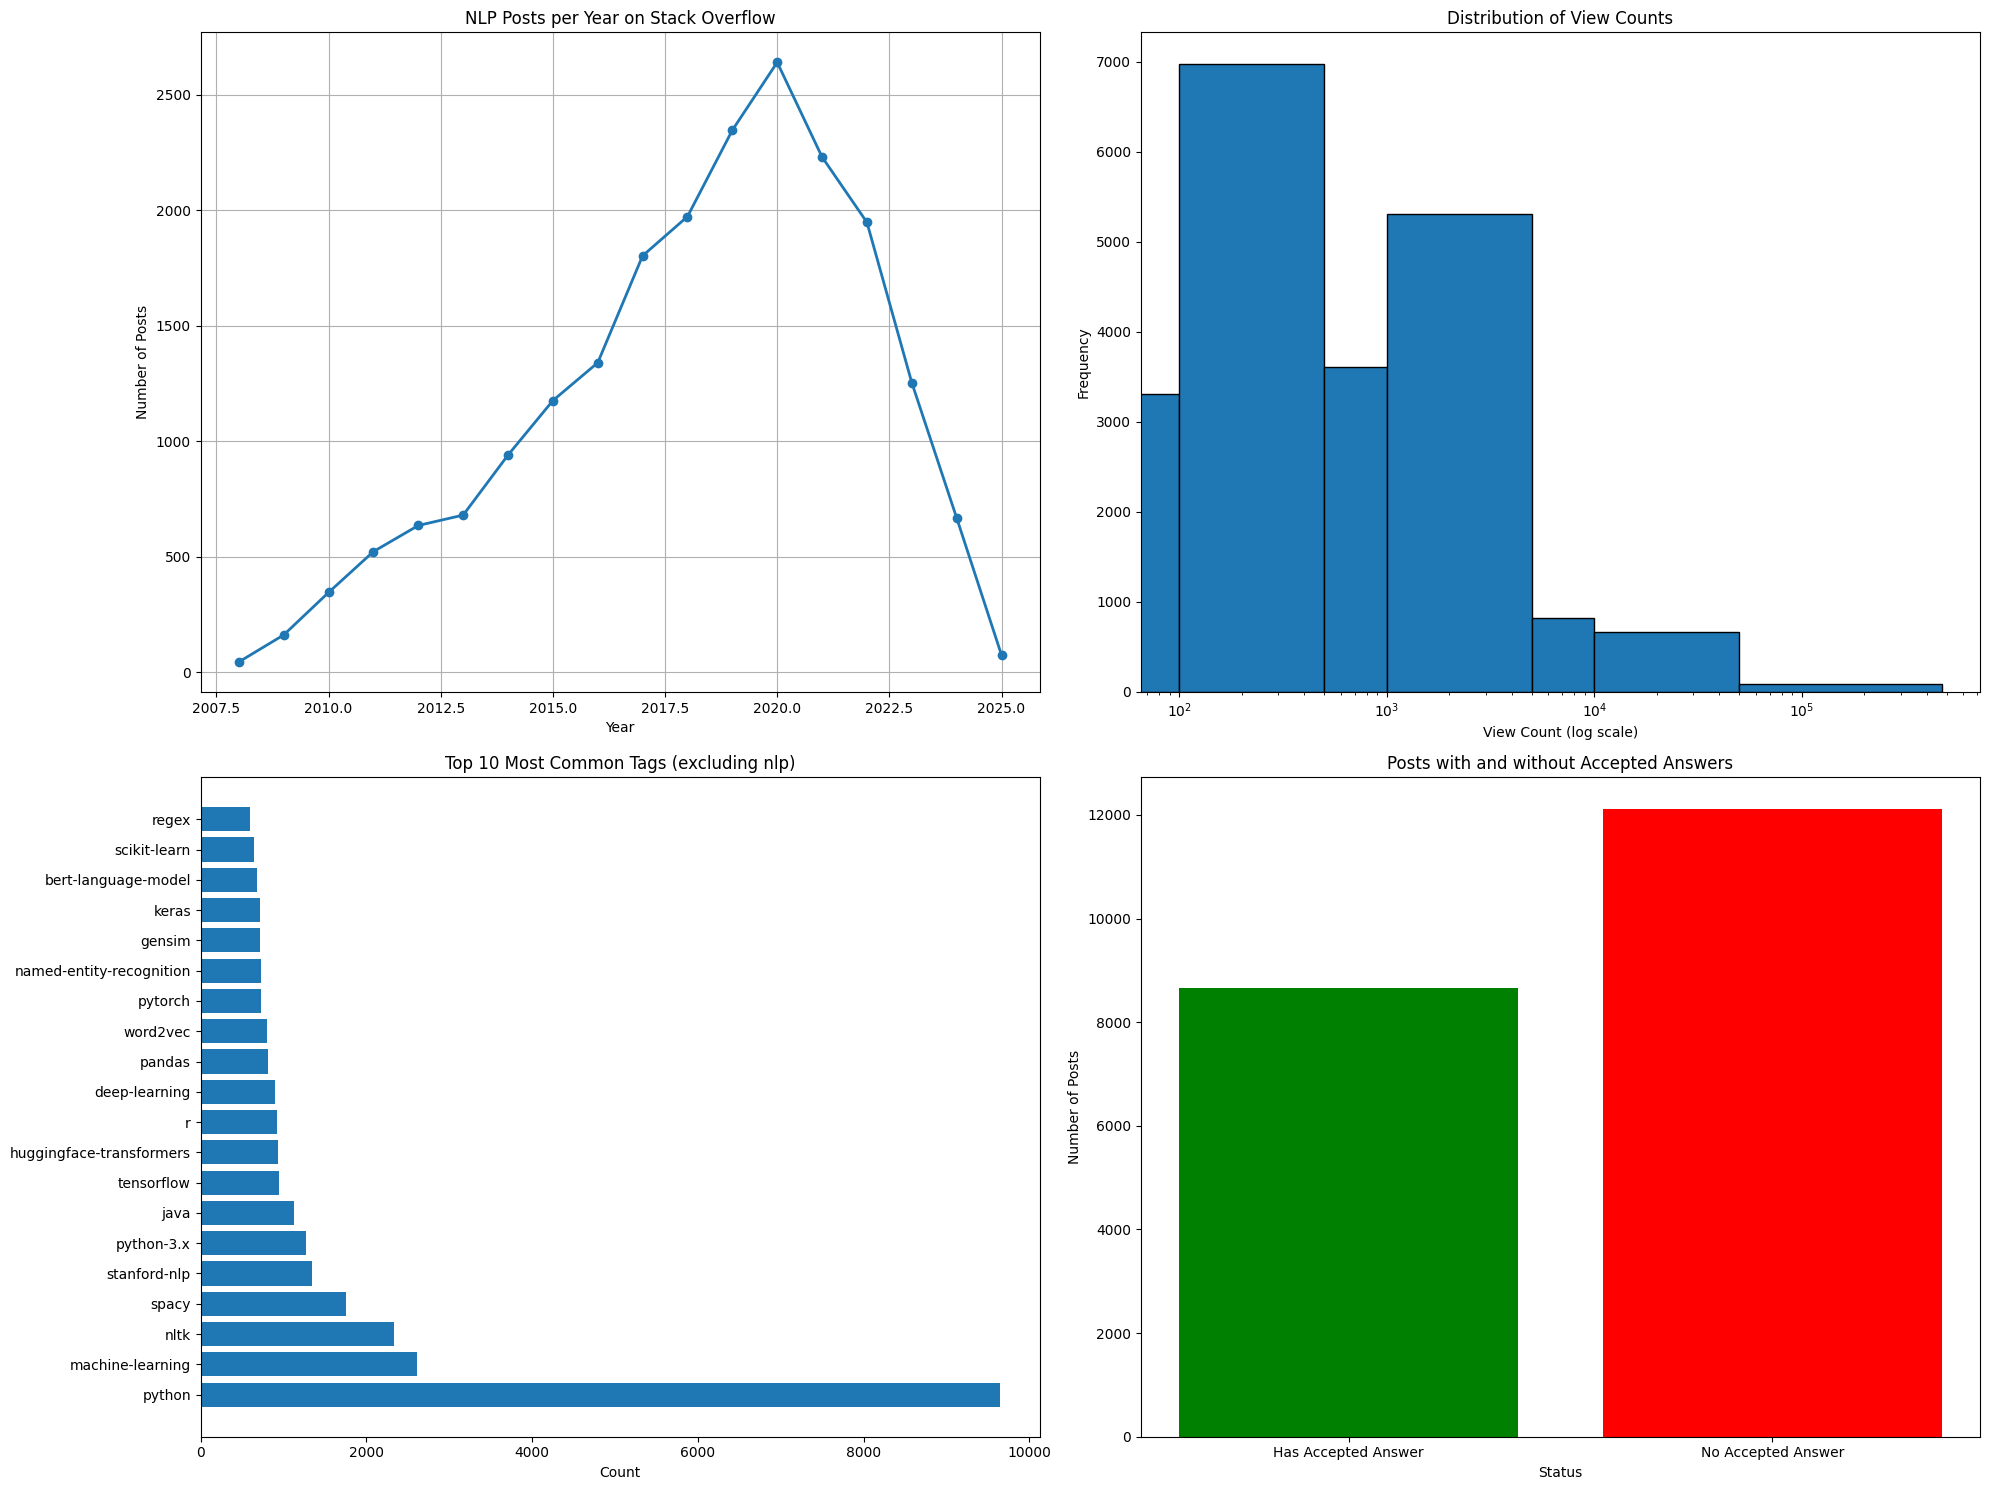

In [12]:
# Create figure with subplots
plt.figure(figsize=(20, 15))

# 1. Posts per year
plt.subplot(2, 2, 1)
df['year'] = df['creation_date'].dt.year
yearly_posts = df['year'].value_counts().sort_index()
plt.plot(yearly_posts.index, yearly_posts.values, marker='o', linewidth=2)
plt.title('NLP Posts per Year on Stack Overflow', fontsize=12)
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.grid(True)

# 2. Distribution of view counts
plt.subplot(2, 2, 2)
view_bins = [0, 100, 500, 1000, 5000, 10000, 50000, max(df['view_count'])]
plt.hist(df['view_count'], bins=view_bins, edgecolor='black')
plt.title('Distribution of View Counts', fontsize=12)
plt.xlabel('View Count (log scale)')
plt.ylabel('Frequency')
plt.xscale('log')

# 3. Top 10 most common tags (excluding 'nlp')
plt.subplot(2, 2, 3)
all_tags = []
df['tags'] = [str(tg).replace("[", "").replace("]", "").replace("'", "").replace(" ", "").split(',') for tg in df['tags']]
for tag in df['tags']:
    if isinstance(tag, list):
        all_tags.extend([tg for tg in tag if tg != 'nlp'])
tag_counts = pd.Series(all_tags).value_counts().head(20)
plt.barh(tag_counts.index, tag_counts.values)
plt.title('Top 10 Most Common Tags (excluding nlp)', fontsize=12)
plt.xlabel('Count')

# 4. Posts with and without Accepted answers
plt.subplot(2, 2, 4)
plt.bar(['Has Accepted Answer', 'No Accepted Answer'], [df['accepted_answer'].notna().sum(), df['accepted_answer'].isna().sum()], color=['green', 'red'])
plt.title('Posts with and without Accepted Answers', fontsize=12)
plt.xlabel('Status')
plt.ylabel('Number of Posts')

plt.tight_layout()
plt.show()

# Data Preprocessing

1. Selectcing and Sorting Posts
2. Remove Code Snippets
3. Removing HTML Tags
4. Removing Non-Textual Content (other language symbols and emojis)
5. Removing punctuation marks and special symbols
6. Converting text to lowercase
7. Tokenization
8. Lemmatization
9. Custom Stop word removal

In [13]:
def select_and_sort_posts(df):

    # Select posts with accepted answers
    accepted_answer_df = df[df['accepted_answer'].notna()]

    # Select posts with other answers
    accepted_and_other_df = accepted_answer_df[accepted_answer_df['other_answers'].notna()]

    # Sort by view count and select top 100
    sorted_df = accepted_and_other_df.nlargest(100, 'view_count')

    return sorted_df

In [14]:
sample_df = select_and_sort_posts(df)

In [15]:
# Removing code snippets
def remove_code_snippets(text):

  # Regular expression to match code snippets within <pre><code> tags
  pattern = r'<pre><code>.*?</code></pre>'
  text = re.sub(pattern, '', text, flags=re.DOTALL)

  return text

In [16]:
sample_df['clean_description'] = sample_df['description'].apply(remove_code_snippets)
sample_df['clean_accepted_answer'] = sample_df['accepted_answer'].apply(remove_code_snippets)
sample_df['clean_other_answers'] = sample_df['other_answers'].apply(remove_code_snippets)

In [17]:
# Removing HTML tags
def remove_html_tags(text):

  soup = BeautifulSoup(text, 'html.parser')

  return soup.get_text()

In [18]:
sample_df['clean_title'] = sample_df['title'].apply(remove_html_tags)
sample_df['clean_description'] = sample_df['clean_description'].apply(remove_html_tags)
sample_df['clean_accepted_answer'] = sample_df['clean_accepted_answer'].apply(remove_html_tags)
sample_df['clean_other_answers'] = sample_df['clean_other_answers'].apply(remove_html_tags)

In [19]:
# Removing emojis and other language symbols
def remove_emojis(text):

    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # enclosed characters
                               u"\U00000400-\U000004FF"  # Cyrillic
                               u"\U00004E00-\U00009FFF"  # Chinese
                               u"\U00000370-\U000003FF"  # Greek
                               u"\U00000600-\U000006FF"  # Arabic
                        "]+", flags=re.UNICODE)

    # Removing unicode emojis
    text = emoji_pattern.sub(r'', text)

    # Removing ASCII-style emoticons
    text = re.sub(r'[:;=][\'"]?[-~]?[)(/\\|dpP]', '', text)

    # Removing other common emoticon patterns
    text = re.sub(r'[<>]?[:;=8][\-o\*\']?[)\](\[dDpP/\\{@|]', '', text)

    return text

In [20]:
sample_df['clean_description'] = sample_df['clean_description'].apply(remove_emojis)
sample_df['clean_accepted_answer'] = sample_df['clean_accepted_answer'].apply(remove_emojis)
sample_df['clean_other_answers'] = sample_df['clean_other_answers'].apply(remove_emojis)

In [21]:
def remove_punctuation_and_special_symbols(text):

    # Remove punctuation marks and special symbols
    text = re.sub(r'[^\w\s\-_.]', ' ', text)
    text = ' '.join(text.split())

    # Remove newline character
    text = text.replace('\n', '')

    return text

In [22]:
sample_df['clean_title'] = sample_df['clean_title'].apply(remove_punctuation_and_special_symbols)
sample_df['clean_description'] = sample_df['clean_description'].apply(remove_punctuation_and_special_symbols)
sample_df['clean_accepted_answer'] = sample_df['clean_accepted_answer'].apply(remove_punctuation_and_special_symbols)
sample_df['clean_other_answers'] = sample_df['clean_other_answers'].apply(remove_punctuation_and_special_symbols)

In [23]:
# Converting text to lowercase
sample_df['clean_title'] = sample_df['clean_title'].str.lower()
sample_df['clean_description'] = sample_df['clean_description'].str.lower()
sample_df['clean_accepted_answer'] = sample_df['clean_accepted_answer'].str.lower()
sample_df['clean_other_answers'] = sample_df['clean_other_answers'].str.lower()

In [24]:
nlp = spacy.load('en_core_web_sm')

In [25]:
# Tokenization
def tokenize_text(text):
    if isinstance(text, list):
        text = ' '.join(text)
    doc = nlp(text)
    tokens = [token.text for token in doc]
    return tokens

sample_df['title_tokens'] = sample_df['clean_title'].apply(tokenize_text)
sample_df['description_tokens'] = sample_df['clean_description'].apply(tokenize_text)
sample_df['accepted_answer_tokens'] = sample_df['clean_accepted_answer'].apply(tokenize_text)
sample_df['other_answers_tokens'] = sample_df['clean_other_answers'].apply(tokenize_text)
sample_df['tags_tokens'] = sample_df['tags'].apply(tokenize_text)

In [26]:
# Lemmatization
def lemmatize_text(tokens):
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_ for token in doc]
    return lemmas

sample_df['title_lemmas'] = sample_df['title_tokens'].apply(lemmatize_text)
sample_df['description_lemmas'] = sample_df['description_tokens'].apply(lemmatize_text)
sample_df['accepted_answer_lemmas'] = sample_df['accepted_answer_tokens'].apply(lemmatize_text)
sample_df['other_answers_lemmas'] = sample_df['other_answers_tokens'].apply(lemmatize_text)
sample_df['tags_lemmas'] = sample_df['tags_tokens'].apply(lemmatize_text)

In [27]:
stop_words = set(nltk.corpus.stopwords.words('english'))

# Custom stop words removal
programming_stop_words = {'nlp', 'import', 'return', 'code', 'data', 'output', 'input', 'file', 'result', 'value', 'string', 'example', 'use', 'need', 'want', 'work', 'list', 'case', 'way', 'make', 'see', 'find', 'give', 'take', 'function', 'method', 'variable', 'python', 'word', 'text', 'sentence', 'document', 'name', 'try', 'look', 'follow', 'may', 'well', 'know', 'question', 'good', 'create', 'self', 'learn', 'system', 'get'}

number_words = {'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty', 'thirty', 'forty', 'fifty', 'sixty', 'seventy', 'eighty', 'ninety', 'hundred', 'thousand', 'million', 'billion', 'trillion', 'first', 'second', 'third', '1st', '2nd', '3rd'}

custom_stop_words = (stop_words | programming_stop_words) | number_words

def remove_customized_stop_words(tokens):
    doc = nlp(" ".join(tokens))
    filtered_tokens = [token for token in doc if token.text not in custom_stop_words]
    filtered_tokens = [token for token in filtered_tokens if len(token.text) > 2 and token.pos_ not in ['NUM']]
    return filtered_tokens

sample_df['title_lemmas'] = sample_df['title_lemmas'].apply(remove_customized_stop_words)
sample_df['description_lemmas'] = sample_df['description_lemmas'].apply(remove_customized_stop_words)
sample_df['accepted_answer_lemmas'] = sample_df['accepted_answer_lemmas'].apply(remove_customized_stop_words)
sample_df['other_answers_lemmas'] = sample_df['other_answers_lemmas'].apply(remove_customized_stop_words)
sample_df['tags_lemmas'] = sample_df['tags_lemmas'].apply(remove_customized_stop_words)

In [28]:
sample_df.head(5)

,title,description,tags,accepted_answer,other_answers,creation_date,view_count,score,year,clean_description,...,title_tokens,description_tokens,accepted_answer_tokens,other_answers_tokens,tags_tokens,title_lemmas,description_lemmas,accepted_answer_lemmas,other_answers_lemmas,tags_lemmas
11061,spaCy: Can&#39;t find model &#39;en_core_web_s...,<p>What is the difference between <code>spacy....,"[python, python-3.x, nlp, spacy]",<p>The answer to your misunderstanding is a Un...,['<p>Initially I downloaded two en packages us...,2019-01-23 19:24:21,472647.0,178.0,2019.0,what is the difference between spacy.load en_c...,...,"[spacy, can, t, find, model, en_core_web_sm, o...","[what, is, the, difference, between, spacy.loa...","[the, answer, to, your, misunderstanding, is, ...","[initially, i, downloaded, two, en, packages, ...","[python, python-3.x, nlp, spacy]","[spacy, model, en_core_web_sm, window, anacond...","[difference, spacy.load, en_core_web_sm, spacy...","[answer, misunderstanding, unix, concept, soft...","[initially, download, package, statement, anac...","[python-3.x, spacy]"
16813,"How to compute precision, recall, accuracy and...",<p>I'm working in a sentiment analysis problem...,"[python, machine-learning, scikit-learn, nlp]",<p>I think there is a lot of confusion about w...,"[""<p>Lot of very detailed answers here but I d...",2015-07-15 04:17:36,333792.0,147.0,2015.0,i m working in a sentiment analysis problem th...,...,"[how, to, compute, precision, recall, accuracy...","[i, m, working, in, a, sentiment, analysis, pr...","[i, think, there, is, a, lot, of, confusion, a...","[lot, of, very, detailed, answers, here, but, ...","[python, machine, -, learning, scikit, -, lear...","[compute, precision, recall, accuracy, score, ...","[sentiment, analysis, problem, like, unbalance...","[think, lot, confusion, weight, sure, precisel...","[lot, detailed, answer, think, answer, right, ...","[machine, scikit]"
19684,How to compute the similarity between two text...,<p>I want to take two documents and determine ...,"[python, nlp]",<p>The common way of doing this is to transfor...,"['<p>Identical to @larsman, but with some prep...",2012-01-17 15:51:09,316362.0,287.0,2012.0,i want to take two documents and determine how...,...,"[how, to, compute, the, similarity, between, t...","[i, want, to, take, two, documents, and, deter...","[the, common, way, of, doing, this, is, to, tr...","[identical, to, larsman, but, with, some, prep...","[python, nlp]","[compute, similarity]","[determine, similar, programming, language, fi...","[common, transform, idf, vector, compute, cosi...","[identical, larsman, preprocessing, nimport, n...",[]
11724,googletrans stopped working with error &#39;No...,<p>I was trying <code>googletrans</code> and i...,"[python, nlp, google-translate, googletrans]",<p><strong>Update 01/12/2020:</strong> This is...,['<h3><strong>Update 06.12.20: A new \'officia...,2018-09-22 10:29:08,233910.0,224.0,2018.0,i was trying googletrans and it was working qu...,...,"[googletrans, stopped, working, with, error, n...","[i, was, trying, googletrans, and, it, was, wo...","[update, 01, 12, 2020, this, issue, re, -, eme...","[update, 06.12.20, a, new, official, alpha, ve...","[python, nlp, google, -, translate, googletrans]","[googletrans, stop, error, nonetype, object, a...","[googletran, quite, since, morning, start, err...","[update, issue, emerge, lately, apparently, ca...","[update, 06.12.20, new, official, alpha, versi...","[google, translate, googletran]"
15853,How to return history of validation loss in Keras,<p>Using Anaconda Python 2.7 Windows 10.</p>\n...,"[python, neural-network, nlp, deep-learning, k...",<p>It's been solved.</p>\n<p>The losses only s...,"[""<p>Just an example started from</p>\n\n<pre>...",2016-04-30 08:45:50,211419.0,78.0,2016.0,using anaconda python 2.7 windows 10. i am tra...,...,"[how, to, return, history, of, validation, los...","[using, anaconda, python, 2.7, windows, 10, .,...","[it, s, been, solved,

# Visualization

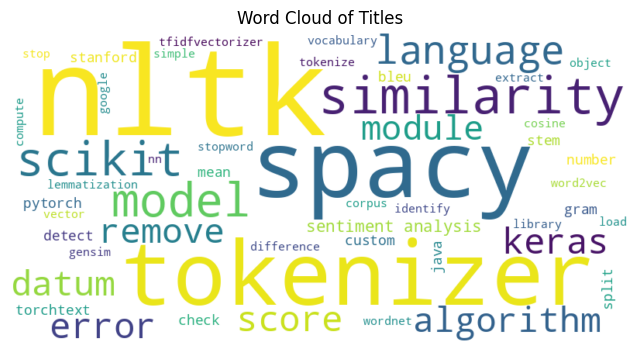

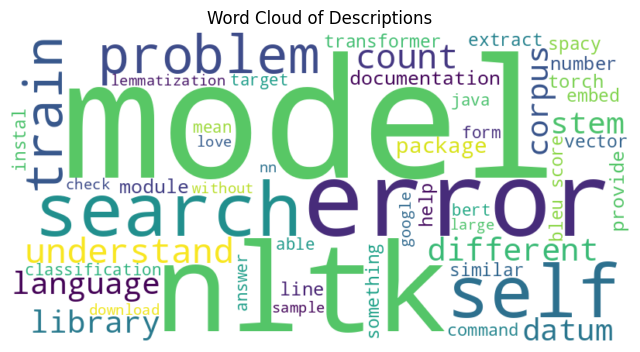

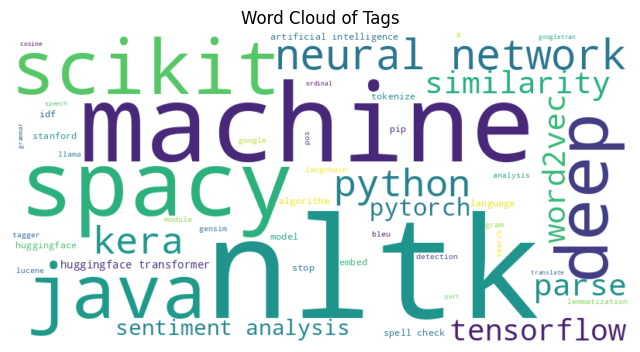

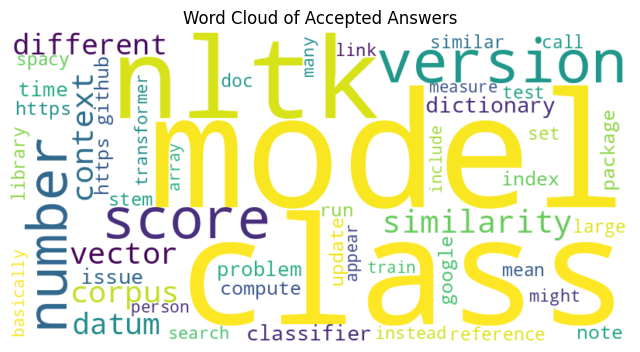

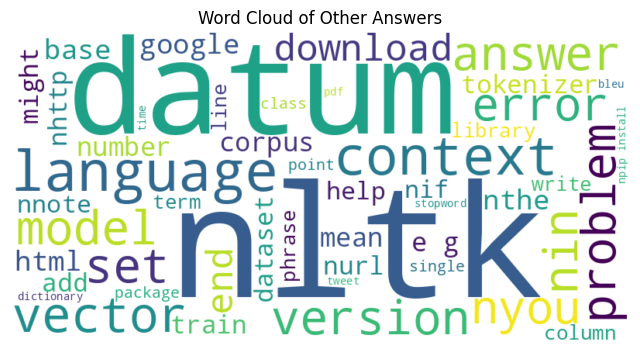

In [30]:
# Print Word cloud of titles
all_titles = ' '.join(sample_df['title_lemmas'].astype(str))
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     max_words=50).generate(all_titles)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Titles')
plt.show()

# for space between two word maps
print()

# Print Word cloud of descriptions
all_description = ' '.join(sample_df['description_lemmas'].astype(str))
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     max_words=50).generate(all_description)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Descriptions')
plt.show()

# for space between two word maps
print()

# Print Word cloud of tags
all_tags = ' '.join(sample_df['tags_lemmas'].astype(str))
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     max_words=50).generate(all_tags)
plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tags')
plt.show()

# for space between two word maps
print()

# Print Word cloud of accepted answers
all_accepted_answers = ' '.join(sample_df['accepted_answer_lemmas'].astype(str))
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     max_words=50).generate(all_accepted_answers)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Accepted Answers')
plt.show()

# for space between two word maps
print()

# Print Word cloud of other answers
all_other_answers = ' '.join(sample_df['other_answers_lemmas'].astype(str))
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     max_words=50).generate(all_other_answers)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Other Answers')
plt.show()

# Categorization

In [31]:
# Categories and their keywords
category_keywords = {
    'NLP Libraries and Tools': ['spacy', 'scikit', 'googletrans', 'keras', 'langdetect', 'grammar', 'package', 'word2vec', 'nltk_data', 'datefinder', 'tensorflow', 'ne_chunk', 'languageidentifi', 'wordnet', 'lingpipe', 'jazzy', 'huggingface', 'pytorch', 'elasticsearch', 'langchain', 'transformers'],
    'POS and NER': ['nnp', 'entity', 'pos', 'ner', 'speech', 'noun', 'tagging'],
    'Text Preprocessing': ['lemmatization', 'stem', 'stopword', 'token', 'tokenizer', 'tokenize', 'countvectorizer', 'unigrams', 'bigram', 'trigram', 'ordinal', 'tex', 'tfidf', 'lowercase'],
    'Model Development': ['train', 'chatbot', 'cluster', 'cbow', 'tune'],
    'Error Debugging': ['error', 'warning', 'typeerror', 'weird', 'problem', 'failed'],
    'Information Extraction': ['conll', 'extract', 'maui'],
    'Environment Setup': ['window', 'python2.7', 'ubuntu', 'instal', 'version', 'download'],
    'Text Similarity': ['cosine', 'misspelled', 'similarity', 'spell', 'sparse'],
    'Translation and Language Recognition' : ['translate', 'trans', 'Chinese', 'langdetect', 'languageidentifi'],
    'Model Evaluation': ['precision', 'recall', 'accuracy', 'loss', 'evaluate', 'bleu', 'score'],
    'Text Classification': ['classifier', 'bert'],
    'Sentiment Analysis': ['sentiment', 'positive', 'negative']
}

def labelize_text(row):
    # Combine all relevant text fields
    combined_text = ' '.join([
        ' '.join([token.text for token in row['title_lemmas']]),
        ' '.join([token.text for token in row['description_lemmas']]),
        ' '.join([token.text for token in row['accepted_answer_lemmas']]),
        ' '.join([token.text for token in row['tags_lemmas']])
    ])

    # Initialize categories for this text
    categories = []

    # Check for each category's keywords
    for category, keywords in category_keywords.items():
        for keyword in keywords:
            if any(k in combined_text for k in [' ' + keyword, ' ' + keyword + ' ', keyword + ' ']):
                if category not in categories:
                    categories.append(category)

    # Return comma-separated categories or 'Uncategorized' if none found
    return ','.join(categories) if categories else 'Uncategorized'

In [32]:
# Apply categorization
sample_df['categories'] = sample_df.apply(labelize_text, axis=1)

# Count number of posts in each category
category_counts = pd.DataFrame(
    [cat.strip() for cats in sample_df['categories'].str.split(',') for cat in cats]
).value_counts().reset_index()
category_counts.columns = ['Category', 'Count']

# Print results
print("Number of posts in each category:")
print(category_counts)

Number of posts in each category:
                                Category  Count
0                NLP Libraries and Tools     66
1                     Text Preprocessing     49
2                        Error Debugging     41
3                            POS and NER     37
4                      Environment Setup     34
5                      Model Development     24
6                        Text Similarity     19
7                       Model Evaluation     17
8   Translation and Language Recognition     16
9                 Information Extraction     14
10                    Sentiment Analysis     11
11                   Text Classification     10


Sample posts from each category:

NLP Libraries and Tools:
1. spaCy: Can&#39;t find model &#39;en_core_web_sm&#39; on windows 10 and Python 3.5.3 :: Anaconda custom (64-bit)
2. How to compute precision, recall, accuracy and f1-score for the multiclass case with scikit learn?

POS and NER:
1. How to compute precision, recall, accuracy and f1-score for the multiclass case with scikit learn?
2. googletrans stopped working with error &#39;NoneType&#39; object has no attribute &#39;group&#39;

Text Preprocessing:
1. How to compute the similarity between two text documents?
2. googletrans stopped working with error &#39;NoneType&#39; object has no attribute &#39;group&#39;

Model Development:
1. How to compute precision, recall, accuracy and f1-score for the multiclass case with scikit learn?
2. How to return history of validation loss in Keras

Error Debugging:
1. spaCy: Can&#39;t find model &#39;en_core_web_sm&#39; on windows 10 and Python 3.5.3 :: Anaconda custom (64-bit)
2. How to comput

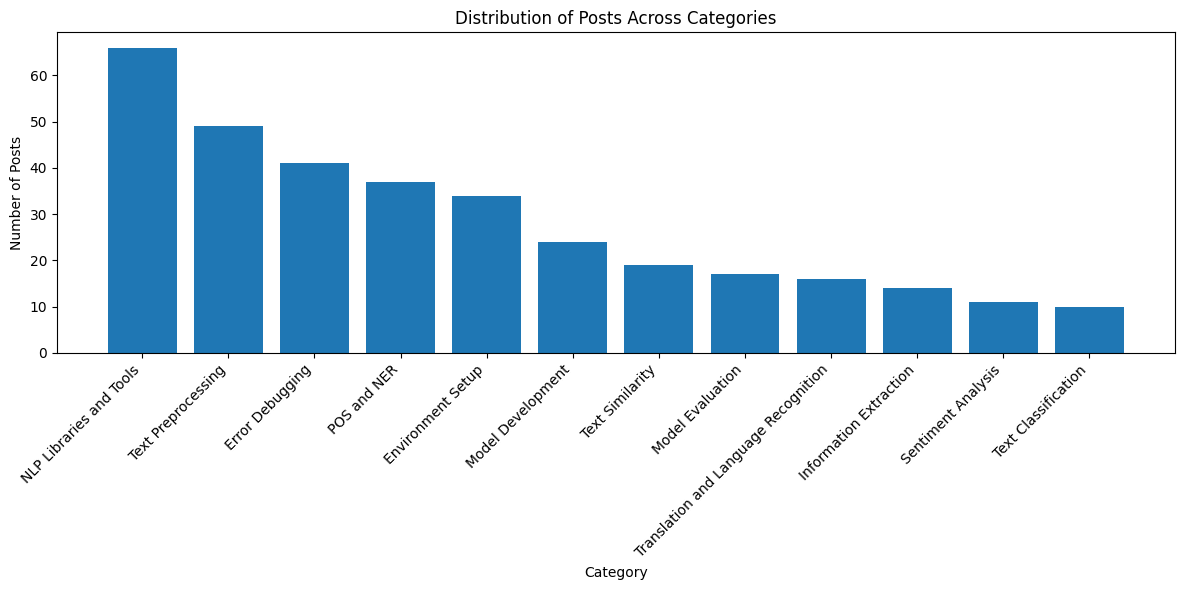


Posts with multiple categories:

Title: spacy can t find model en_core_web_sm on windows 10 and python 3.5.3 anaconda custom 64-bit
Categories: NLP Libraries and Tools,Error Debugging,Environment Setup

Title: how to compute precision recall accuracy and f1-score for the multiclass case with scikit learn
Categories: NLP Libraries and Tools,POS and NER,Model Development,Error Debugging,Environment Setup,Model Evaluation,Text Classification,Sentiment Analysis

Title: how to compute the similarity between two text documents
Categories: NLP Libraries and Tools,Text Preprocessing,Text Similarity,Translation and Language Recognition

Title: googletrans stopped working with error nonetype object has no attribute group
Categories: NLP Libraries and Tools,POS and NER,Text Preprocessing,Error Debugging,Environment Setup,Translation and Language Recognition

Title: how to return history of validation loss in keras
Categories: NLP Libraries and Tools,Model Development,Error Debugging,Environment 

In [33]:
# Display sample posts from each category
print("Sample posts from each category:")
for category in category_keywords.keys():
    print(f"\n{category}:")
    sample_posts = sample_df[sample_df['categories'].str.contains(category, na=False)]['title'].head(2)
    for idx, title in enumerate(sample_posts, 1):
        print(f"{idx}. {title}")

# Create a bar plot of category distribution
plt.figure(figsize=(12, 6))
plt.bar(category_counts['Category'], category_counts['Count'])
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Posts Across Categories')
plt.xlabel('Category')
plt.ylabel('Number of Posts')
plt.tight_layout()
plt.show()

# Print posts with multiple categories
print("\nPosts with multiple categories:")
multi_category_posts = sample_df[sample_df['categories'].str.contains(',')]
for idx, row in multi_category_posts.head().iterrows():
    print(f"\nTitle: {row['clean_title']}")
    print(f"Categories: {row['categories']}")